In [3]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks

In [4]:
KB = c.Boltzmann
hbar = c.Planck

In [5]:
def read_files(dir = 'F:\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set1\\T_190\\'):

    dictionaries = []

    for (i,filename) in enumerate(os.listdir(dir)):
        my_source = dir + filename
        with h5.File(my_source, 'r') as r:
            group = r.require_group(name='raw_data')
            dic = dict()
            for c in group.items():
                dic[c[0]] = c[1][:]
        dictionaries.append(dic)
    return dictionaries

In [6]:
dfs = read_files()

In [7]:
F = dfs[3]['f']
I = dfs[3]['i']
Q = dfs[3]['q']
S21 = np.sqrt(I**2 + Q**2)

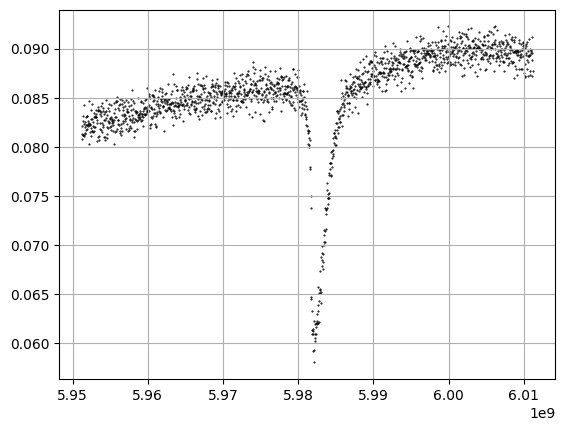

In [8]:
plt.scatter(F, S21, s=1, marker='.', color='black')
plt.grid()

In [9]:
x, y = find_peaks(-S21, -0.06)
x_min = F[x[np.argmin(y['peak_heights'])]]
y_min = -max(y['peak_heights'])

Normalize and center data about minimum

In [10]:
S21 = [(x - y_min) / (max(S21) - y_min) for x in S21]
F = (F-x_min)/x_min

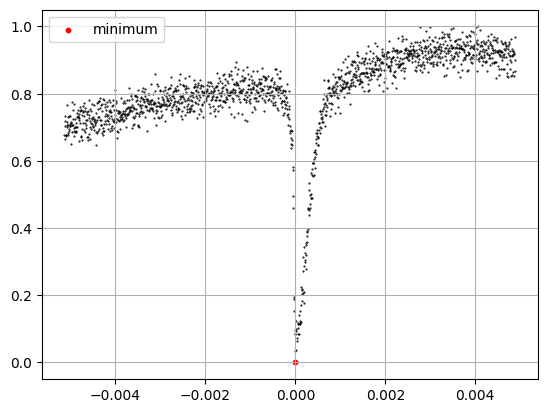

In [11]:
plt.scatter(F, S21, s=1, marker='.', color='black')
plt.scatter(0, min(S21), s=10, marker='o', color='red', label='minimum')
plt.legend()
plt.grid()

Separating bg from resonance data + fitting bg with 1st order pol

In [12]:
condition = lambda x: (x<-0.002 or x>0.002)
idxs = [i for i,x in enumerate(F) if condition(x)]
F_bg = np.array([F[i] for i in idxs])
S21_bg = np.array([S21[i] for i in idxs])
F_res = np.array([F[i] for i,x in enumerate(F) if not condition(x)])
S21_res = np.array([S21[i] for i,x in enumerate(F) if not condition(x)])
params = np.polyfit(F, S21,1)
rms = np.sqrt(np.mean((np.polyval(params, F_bg)-S21_bg)**2))

Plot 

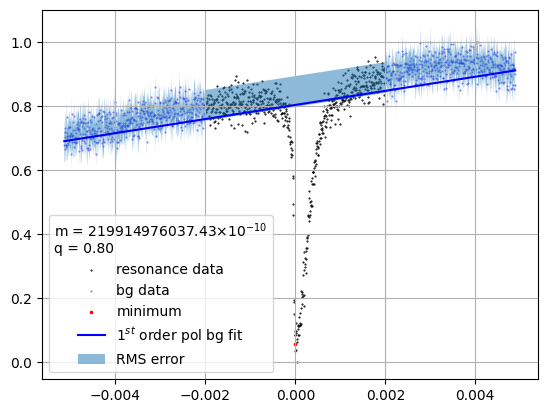

In [13]:
plt.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
plt.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
plt.scatter(0, y_min, s=10, marker='.', color='red', label='minimum')
plt.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
plt.grid()
cond = lambda x: x in F_bg
plt.fill_between(F_bg, S21_bg+rms, S21_bg-rms, alpha=0.5, label='RMS error')
title = [f"m = {params[0]*1e10:.2f}"+r"$\times 10^{-10}$", f"q = {params[1]:.2f}"]
plt.legend(title = "\n".join(title))

Estimate FWHM (using res data only)

In [14]:
def FWHM(x,y):
    max_y = np.max(y)
    half_max_y = max_y / 2.0

    condition = lambda t: (t<=half_max_y*(1+0.01) or t>=half_max_y*(1-0.01))
    indices = [i for i,y in enumerate(y) if condition(y)]
    if len(indices) < 2:
        raise ValueError("Cannot find FWHM. The curve might not cross half of its maximum.")

    # Get corresponding x values
    x_half_max = [x[index] for index in indices]

    # Calculate FWHM
    return np.abs(x_half_max[-1] - x_half_max[0])

Initial parameters estimation

In [15]:
fwhm = FWHM(F_res, S21_res)
Q_tot = x_min/(fwhm*1e9)
Q_c = 2.5*1e3
phi0 = 0.02

In [16]:
def resonance_model(x, Q, Qc,phi0):
    return 1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q)))

def model(x, m, q, Q, Qc,phi0):
    par = np.array([m,q])
    pol = np.polyval(par, x)
    res = resonance_model(x, Q,Qc,phi0)
    return np.abs(res)*pol

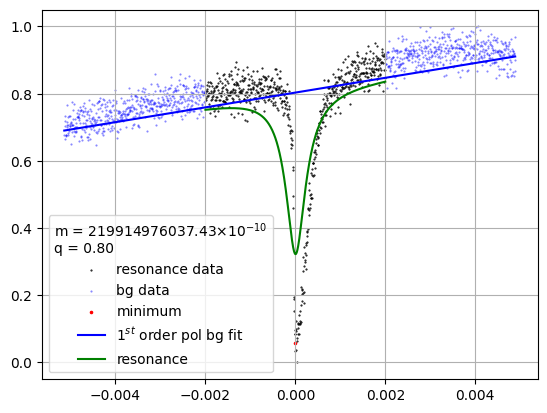

In [17]:
plt.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
plt.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
plt.scatter(0, y_min, s=10, marker='.', color='red', label='minimum')
plt.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
plt.plot(F_res, model(F_res, params[0], params[1], Q_tot, Q_c, phi0), color='green',label='resonance')
plt.grid()
title = [f"m = {params[0]*1e10:.2f}"+r"$\times 10^{-10}$", f"q = {params[1]:.2f}"]

plt.legend(title = "\n".join(title))

In [18]:
p0 = [params[0], params[1], Q_tot, Q_c,phi0]
lsq = cost.LeastSquares(F_res,S21_res, rms, model)
m = Minuit(lsq, *p0)

In [19]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 691 (χ²/ndof = 1.1)        │              Nfcn = 153              │
│ EDM = 4.77e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   50.5    │    1.9    │            │            │         │         │       │
│ 1 │ q    │  0.8456   │  0.0026   │            │            │         │         │       │
│ 2 │ Q    │  2.09e3   │  0.04e3   │            │            │         │         │       │
│ 3 │ Qc   │  2.09e3   │  0.05e3   │            │            │         │         │       │
│ 4 │ phi0 │   0.307   │   0.008   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────────────────────────────────┐
│      │          m          q          Q         Qc       phi0 │
├──────┼────────────────────────────────────────────────────────┤
│    m │       3.63     953e-6        -17        -16    4.16e-3 │
│    q │     953e-6   6.68e-06 -58.473e-3 -50.082e-3      -4e-6 │
│    Q │        -17 -58.473e-3   1.48e+03      1.1e3   45.33e-3 │
│   Qc │        -16 -50.082e-3      1.1e3   2.25e+03  221.93e-3 │
│ phi0 │    4.16e-3      -4e-6   45.33e-3  221.93e-3   6.92e-05 │
└──────┴────────────────────────────────────────────────────────┘

Text(0.5, 1.0, 'Resonance 3')

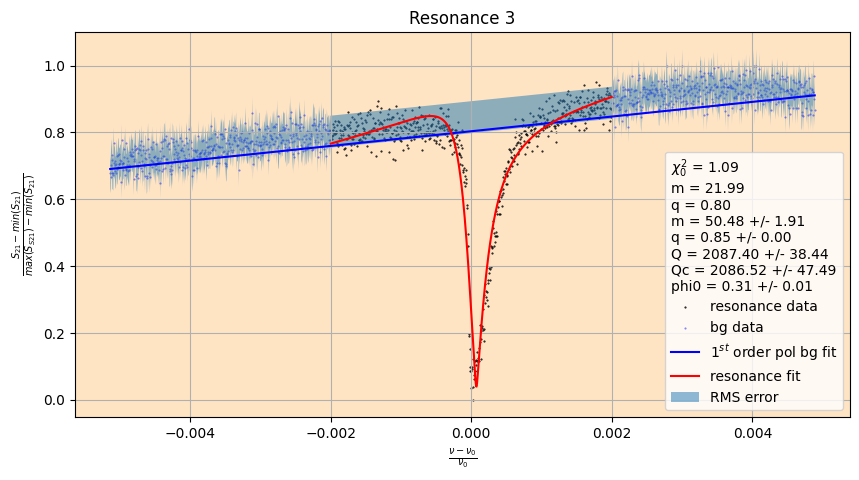

In [20]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
axs.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
axs.set_ylabel(r"$\frac{S_{21}-min(S_{21})}{max(S_{S21})-min(S_{21})}$")
axs.set_xlabel(r"$\frac{\nu-\nu_{0}}{\nu_{0}}$")
axs.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
axs.plot(F_res, model(F_res, *m.values), color='red',label='resonance fit')
axs.fill_between(F_bg, S21_bg+rms, S21_bg-rms, alpha=0.5, label='RMS error')
axs.grid()

chi2 = m.fval
ndof = m.ndof

title = [r"$\chi_{0}^2$ = "+f"{chi2/ndof:.2f}", f"m = {params[0]:.2f}", f"q = {params[1]:.2f}"]
for par in m.parameters:
            title.append(
                f"{par} = {m.values[par]:.2f} +/- {m.errors[par]:.2f}"
            )
axs.legend(title = "\n".join(title))
axs.set_facecolor('bisque')
axs.set_title("Resonance 3")